# LSTM

In [1]:
# imports
import time
import os
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score, precision_score, f1_score, recall_score, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords
import re
import nltk
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('omw-1.4')

C:\Users\User\AppData\Local\Temp/ipykernel_16264/3039973235.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## 1. Data loading and exploration

In [11]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [12]:
ag_news_train_df.shape

(120000, 3)

In [13]:
ag_news_test_df.shape

(7600, 3)

In [14]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [15]:
amazon_reviews_df.shape

(17340, 4)

In [16]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [17]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<AxesSubplot:>

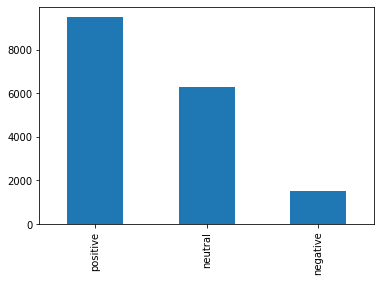

In [18]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<AxesSubplot:>

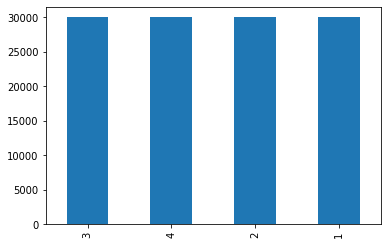

In [19]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

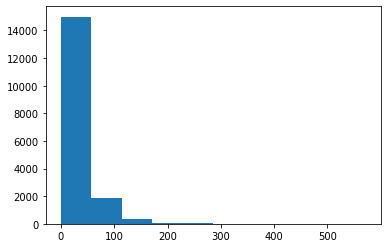

In [20]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

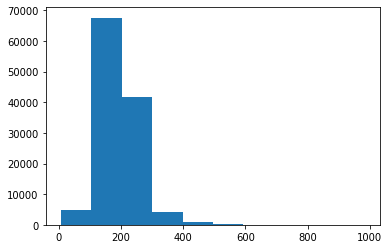

In [21]:
plt.hist(ag_news_train_df.Description.str.len())

In [22]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [23]:
amazon_reviews_df.dropna(inplace=True)

## 2. Train/Val/Test split

In [24]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [25]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [26]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.25)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [27]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [28]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [29]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [30]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.25)

In [31]:
# split the data sets accordignly, so we can perform hyperparameter tuning somewhat successfully

np.random.seed(42)
reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
                                     replace=False, size=y_train_reviews.shape[0]//2)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)

X_train_reviews_half = X_train_reviews.iloc[reviews_train_idx,:]
y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]
X_train_news_eight = X_train_news.iloc[news_train_idx]
y_train_news_eight = y_train_news.iloc[news_train_idx]

In [32]:
# helper function for the reviews data set

def preprocessing_reviews(X, y, sent_length):
    X.drop(['cleaned_review_length', 'review_score'], axis=1, inplace=True)
    corpus = X['cleaned_review'].values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length) 
    
    X = np.array(embedded_docs)
    
    return (X, y)

In [34]:
### helper functions for the news data set 

# Tokenize the sentence into words
lemmatizer = WordNetLemmatizer()

def lemmetize_it(sentence):
    words = nltk.word_tokenize(sentence)
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    lemmas_str = ' '.join(lemmas)
    return lemmas_str

def clean_news_data(X):    
    X = X.apply(lambda x: " ".join(x.lower() for x in x.split()))
    X = X.str.replace('[^\w\s]','', regex=True)
    
    stop = stopwords.words('english')
    X = X.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    # Create a WordNet lemmatizer object
    lemmatizer = WordNetLemmatizer()
    
    X = X.apply(lemmetize_it)
    
    return(X)

def preprocessing_news(X, y, sent_length):
    corpus = X.values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
          
    X = np.array(embedded_docs)
    
    return (X, y)

In [35]:
y_train_reviews.head()

11652     neutral
7240     positive
16483    positive
13353    positive
6024     positive
Name: sentiments, dtype: object

## 3. Model development - Reviews

### 3.1. Model 1 - base model
The parameters were as follows:  
voc_size = 5000  
sent_length = 40  
embedding_vector_features = 40  

The average sentence length of the data is 34, so we chose 40 in the begining to try to capture more of the information. As the data set is small, a slightly bigger sentence length will not take us much longer to train it. And, the rest of the parameters were chosen randomly but that they make sense in the context of the data and the model.

In [36]:
# setting the vocabulary and sentence length
voc_size = 5000
sent_length = 40
embedding_vector_features = 40

In [37]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

In [39]:
X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [43]:
categories = [['negative', 'neutral', 'positive']]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [44]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


We first ran the model.fit on the training data and tested it out on the validation data. We used 3 epochs to see if the model will overfit.  
The results show that the model is overfitting the training data and not generalizing well to the validation data. This can be seen from the increasing difference between training accuracy and validation accuracy as the number of epochs increases.

The training accuracy increases up to 95.6% while the validation accuracy only reaches 82.15%. This suggests that the model is memorizing the training data rather than learning the underlying patterns that can be generalized to the validation set.

The loss is also decreasing on the training set, but increasing on the validation set. This further supports the overfitting issue.


To address the overfitting issue, we will try using regularization techniques like dropout, or simplifying the model architecture.

In [45]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 1s 4ms/step


In [46]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

reviews_m1_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m1_results['train_time'] = train_time
reviews_m1_results['test_time'] = test_time
reviews_m1_results = pd.DataFrame.from_dict(reviews_m1_results)
reviews_m1_results.to_csv('results/lstm/reviews/model_1.csv')
pickle.dump(model, open('models/lstm/reviews/model_1.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-24 18:48:11         2204
metadata.json                                  2023-02-24 18:48:11           64
variables.h5                                   2023-02-24 18:48:11      3107104


In [47]:
reviews_m1_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.615385,0.706637,0.829497,0.781719,0.717173,0.765837,29.191618,1.152139
recall,0.025397,0.750801,0.927034,0.781719,0.567744,0.781719,29.191618,1.152139
f1-score,0.048780,0.728050,0.875558,0.781719,0.550796,0.747379,29.191618,1.152139
support,315.000000,1248.000000,1905.000000,0.781719,3468.000000,3468.000000,29.191618,1.152139


The test accuracy is 78 % which is very similar to the validation results, but this is a balanced accuracy, and the model.fit was a normal accuracy which doesn't take into account the distribution of the target variable properly. Furthermore, we will try to add dropout layers, or simplify the model architecture.

### 3.2. Model 1 - base model with dropout added
Essentially, we will just add two dropout layers with the probability of neurons not firing at 30%. We just want to see if this small data context, it will make any difference.

In [48]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 40, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 1s 2ms/step


In [50]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

reviews_m2_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m2_results['train_time'] = train_time
reviews_m2_results['test_time'] = test_time
reviews_m2_results = pd.DataFrame.from_dict(reviews_m2_results)
reviews_m2_results.to_csv('results/lstm/reviews/model_2.csv')
pickle.dump(model, open('models/lstm/reviews/model_2.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-24 18:49:17         2874
metadata.json                                  202

In [51]:
reviews_m2_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.476190,0.725844,0.862525,0.786621,0.688187,0.778248,20.583426,0.96846
recall,0.349206,0.740385,0.889239,0.786621,0.659610,0.786621,20.583426,0.96846
f1-score,0.402930,0.733042,0.875678,0.786621,0.670550,0.781409,20.583426,0.96846
support,315.000000,1248.000000,1905.000000,0.786621,3468.000000,3468.000000,20.583426,0.96846


After adding two dropout layers with the probability of 0.3, we get an accuracy of 78% which isn't an improvement really.  
We will now change the voc_size and the sent_length to see if that can make the results better, and then we will experiment with the model architecture and all of the parameters in hyperparameter tuning.

### 3.3. Model 3 - bigger parameters
We generally tried a bit bigger parameters because then the model can capture more information, as stated earlier, and we do not risk losing on performance.

In [52]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 100
embedding_vector_features = 60

In [54]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

In [55]:
X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [56]:
categories = [['negative', 'neutral', 'positive']]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [57]:
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 60)           600000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              128800    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 729,403
Trainable params: 729,403
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 0s 4ms/step


In [61]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

reviews_m3_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m3_results['train_time'] = train_time
reviews_m3_results['test_time'] = test_time
reviews_m3_results = pd.DataFrame.from_dict(reviews_m3_results)
reviews_m3_results.to_csv('results/lstm/reviews/model_3.csv')
pickle.dump(model, open('models/lstm/reviews/model_3.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                             

In [62]:
reviews_m3_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.639073,0.796488,0.910089,0.845444,0.781883,0.844592,11.067574,0.558506
recall,0.612698,0.799679,0.913911,0.845444,0.775430,0.845444,11.067574,0.558506
f1-score,0.625608,0.798081,0.911996,0.845444,0.778561,0.844989,11.067574,0.558506
support,315.000000,1248.000000,1905.000000,0.845444,3468.000000,3468.000000,11.067574,0.558506


The best result is 84 % accuracy, which is an improvement, it mostly happened because we increased the size of the features, and the sent length, and the voc size, so it managed to capture more information. Of, course it does train longer than but that is the trade off we must accept.

### Reviews, Hyperparameter tuning

We experimented with essentially all of the parameters in our setting except. Furthermore, we added another layer to the model to see if different dense activation, and number of units will improve the model. In the begining with our experimentation, we tried different multi layer models, and it really didn't improve the model, so we just included in in the hyperparameter tuning to see if it finds the best model by itself.

In [ ]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

In [ ]:
X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [ ]:
categories = [['negative', 'neutral', 'positive']]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [ ]:
def create_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=hp.Int('voc_size', 5000, 20000, step=2500),
        output_dim=hp.Int('embedding_size', 32, 128, 32),
        input_length = 100))    
    model.add(Bidirectional(LSTM(units=hp.Int('LSTM_units', 32, 128, 32))))
    model.add(Dense(units=hp.Int('dense_units', 10, 50, 10), activation=hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh'])))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss=CategoricalCrossentropy(),
        metrics=[Accuracy()]
    )
    return model

In [ ]:
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='tuning',
    project_name='movie_review_sentiment_analysis'
)

INFO:tensorflow:Reloading Tuner from tuning\movie_review_sentiment_analysis\tuner0.json


INFO:tensorflow:Reloading Tuner from tuning\movie_review_sentiment_analysis\tuner0.json


In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hyperparameters)

In [ ]:
best_hyperparameters.values

{'voc_size': 7500,
 'embedding_size': 64,
 'sent_length': 90,
 'LSTM_units': 64,
 'dense_units': 50,
 'dense_activation': 'relu',
 'learning_rate': 0.01}

### 3.4. Model 4 - with best parameters

{ 'voc_size': 7500,  
 'embedding_size': 64,  
 'sent_length': 90,  
 'LSTM_units': 64,  
 'dense_units': 50,  
 'dense_activation': 'relu',  
 'learning_rate': 0.01 }

In [63]:
# setting the vocabulary and sentence length
voc_size = 7500
sent_length = 90
embedding_vector_features = 64

In [64]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

In [65]:
X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [66]:
categories = [['negative', 'neutral', 'positive']]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [67]:
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.01), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 90, 64)            480000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 50)                6450      
                                                                 
 dense_4 (Dense)             (None, 3)                 153       
                                                                 
Total params: 552,651
Trainable params: 552,651
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 1s 6ms/step


In [69]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

reviews_m4_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m4_results['train_time'] = train_time
reviews_m4_results['test_time'] = test_time
reviews_m4_results = pd.DataFrame.from_dict(reviews_m4_results)
reviews_m4_results.to_csv('results/lstm/reviews/model_4.csv')
pickle.dump(model, open('models/lstm/reviews/model_4.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........3
.........4
.........5
.........6
...

In [70]:
reviews_m4_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.875000,0.728592,0.851585,0.802768,0.818392,0.809451,33.687989,1.943553
recall,0.022222,0.804487,0.930709,0.802768,0.585806,0.802768,33.687989,1.943553
f1-score,0.043344,0.764661,0.889391,0.802768,0.565798,0.767658,33.687989,1.943553
support,315.000000,1248.000000,1905.000000,0.802768,3468.000000,3468.000000,33.687989,1.943553


After finding the best parameters using hyperparameter tuning, we fit the model again and get worse accuracy then before with 80%. This is the case because we used multi layer LSTM in our hyperparameter tuning, and when we also tried manually after the performance was worst than using a single layer LSTM.

### 3.5. Model 5 - best parameters on the augmented data set

In [71]:
X_train = pd.read_csv("data/X_train_reviews_augmented.csv")
y_train = pd.read_csv("data/y_train_reviews_augmented.csv")
y_train = y_train['sentiments']

In [72]:
mask = X_train.isna()

# get the indexes of the NaN values
indexes = mask.index[mask.any(axis=1)].tolist()

In [73]:
X_train.drop(index = indexes, inplace=True)
y_train.drop(index = indexes, inplace=True)

In [74]:
# setting the vocabulary and sentence length
voc_size = 7500
sent_length = 90
embedding_vector_features = 64

In [75]:
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()

In [76]:
X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [77]:
categories = [['negative', 'neutral', 'positive']]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [78]:
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.01), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 90, 64)            480000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 50)                6450      
                                                                 
 dense_6 (Dense)             (None, 3)                 153       
                                                                 
Total params: 552,651
Trainable params: 552,651
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 1s 4ms/step


In [80]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

reviews_m5_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m5_results['train_time'] = train_time
reviews_m5_results['test_time'] = test_time
reviews_m5_results = pd.DataFrame.from_dict(reviews_m5_results)
reviews_m5_results.to_csv('results/lstm/reviews/model_5.csv')
pickle.dump(model, open('models/lstm/reviews/model_5.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........3
.........4
.........5
.........6
...

In [81]:
reviews_m5_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.719858,0.826194,0.897566,0.858131,0.814539,0.855741,38.085537,1.235642
recall,0.644444,0.803686,0.929134,0.858131,0.792421,0.858131,38.085537,1.235642
f1-score,0.680067,0.814785,0.913077,0.858131,0.802643,0.856541,38.085537,1.235642
support,315.000000,1248.000000,1905.000000,0.858131,3468.000000,3468.000000,38.085537,1.235642


### 3.6. Model comparison

In [82]:
reviews_m1_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.615385,0.706637,0.829497,0.781719,0.717173,0.765837,29.191618,1.152139
recall,0.025397,0.750801,0.927034,0.781719,0.567744,0.781719,29.191618,1.152139
f1-score,0.048780,0.728050,0.875558,0.781719,0.550796,0.747379,29.191618,1.152139
support,315.000000,1248.000000,1905.000000,0.781719,3468.000000,3468.000000,29.191618,1.152139


In [83]:
reviews_m2_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.476190,0.725844,0.862525,0.786621,0.688187,0.778248,20.583426,0.96846
recall,0.349206,0.740385,0.889239,0.786621,0.659610,0.786621,20.583426,0.96846
f1-score,0.402930,0.733042,0.875678,0.786621,0.670550,0.781409,20.583426,0.96846
support,315.000000,1248.000000,1905.000000,0.786621,3468.000000,3468.000000,20.583426,0.96846


In [84]:
reviews_m3_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.639073,0.796488,0.910089,0.845444,0.781883,0.844592,11.067574,0.558506
recall,0.612698,0.799679,0.913911,0.845444,0.775430,0.845444,11.067574,0.558506
f1-score,0.625608,0.798081,0.911996,0.845444,0.778561,0.844989,11.067574,0.558506
support,315.000000,1248.000000,1905.000000,0.845444,3468.000000,3468.000000,11.067574,0.558506


In [85]:
reviews_m4_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.875000,0.728592,0.851585,0.802768,0.818392,0.809451,33.687989,1.943553
recall,0.022222,0.804487,0.930709,0.802768,0.585806,0.802768,33.687989,1.943553
f1-score,0.043344,0.764661,0.889391,0.802768,0.565798,0.767658,33.687989,1.943553
support,315.000000,1248.000000,1905.000000,0.802768,3468.000000,3468.000000,33.687989,1.943553


In [86]:
reviews_m5_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.719858,0.826194,0.897566,0.858131,0.814539,0.855741,38.085537,1.235642
recall,0.644444,0.803686,0.929134,0.858131,0.792421,0.858131,38.085537,1.235642
f1-score,0.680067,0.814785,0.913077,0.858131,0.802643,0.856541,38.085537,1.235642
support,315.000000,1248.000000,1905.000000,0.858131,3468.000000,3468.000000,38.085537,1.235642


From all of the models, the best results in the end were on the augmented data set using the best parameters we found using random search by using the Adam optimizer for accuracy. The difference between the augmented and the normal data set were very minor in the end with 83% and 84% respectively.

## 4. Model development - News

In [ ]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

In [ ]:
X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

In [ ]:
categories = [['negative', 'neutral', 'positive']]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [ ]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

### 4.1. Model 1 - base
Again, same thing starting with a bit bigger parameters than the average and going from there.

In [87]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 150
embedding_vector_features = 50

In [88]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

In [89]:
X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

In [90]:
X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_news(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [92]:
categories = [[1, 2, 3, 4]]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [93]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 50)           500000    
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dense_7 (Dense)             (None, 4)                 404       
                                                                 
Total params: 560,804
Trainable params: 560,804
Non-trainable params: 0
_________________________________________________________________
None


In [94]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

238/238 [==============================] - 1s 4ms/step


In [95]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

news_m1_results = classification_report(y_test, y_pred, output_dict=True)

news_m1_results['train_time'] = train_time
news_m1_results['test_time'] = test_time
news_m1_results = pd.DataFrame.from_dict(news_m1_results)
news_m1_results.to_csv('results/lstm/news/model_1.csv')
pickle.dump(model, open('models/lstm/news/model_1.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-24 19:02:55         2219
metadata.json                                  2023-02-24 19:02:55           64
variables.h5                                   2023-02-24 19:02:55      6755904


In [96]:
news_m1_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.934955,0.924812,0.879956,0.844631,0.895132,0.896089,0.896089,83.513696,1.598917
recall,0.870000,0.971053,0.841053,0.898421,0.895132,0.895132,0.895132,83.513696,1.598917
f1-score,0.901309,0.947368,0.860065,0.870696,0.895132,0.894859,0.894859,83.513696,1.598917
support,1900.000000,1900.000000,1900.000000,1900.000000,0.895132,7600.000000,7600.000000,83.513696,1.598917


Again, we used model.fit with multiple epochs to see how the model functions better, but we removed it from the notebook for the sake of making everything consistent and clean.

We got an accuracy of 89.5% which is a great start, we will try to do experiment in the same manner as we did in the first data set, and see if we could improve the results.

### 4.2. Model 2 - bigger parameters

In [97]:
# setting the vocabulary and sentence length
voc_size = 20000
sent_length = 200
embedding_vector_features = 100

In [98]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

In [99]:
X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

In [100]:
X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_news(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [101]:
categories = [[1, 2, 3, 4]]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [102]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 100)          2000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 4)                 804       
                                                                 
Total params: 2,161,604
Trainable params: 2,161,604
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

238/238 [==============================] - 2s 7ms/step


In [104]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

news_m2_results = classification_report(y_test, y_pred, output_dict=True)

news_m2_results['train_time'] = train_time
news_m2_results['test_time'] = test_time
news_m2_results = pd.DataFrame.from_dict(news_m2_results)
news_m2_results.to_csv('results/lstm/news/model_2.csv')
pickle.dump(model, open('models/lstm/news/model_2.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                             

In [105]:
news_m2_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.952299,0.949205,0.874729,0.845186,0.903553,0.905355,0.905355,84.700018,2.329258
recall,0.872105,0.973684,0.848947,0.919474,0.903553,0.903553,0.903553,84.700018,2.329258
f1-score,0.910440,0.961289,0.861645,0.880766,0.903553,0.903535,0.903535,84.700018,2.329258
support,1900.000000,1900.000000,1900.000000,1900.000000,0.903553,7600.000000,7600.000000,84.700018,2.329258


Just a slight increase in performance after increasing the voc_size and sent_length, which means the older values already capture enough information and increasin the size would only make our model run slower without much benefit.

### News, Hyperparameter tuning

In [106]:
# setting the vocabulary and sentence length
voc_size = 20000
sent_length = 200
embedding_vector_features = 50

In [107]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

In [109]:
X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

In [110]:
X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_news(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [111]:
categories = [[1, 2, 3, 4]]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [ ]:
def create_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=hp.Int('voc_size', 15000, 30000, step=5000),
        output_dim=hp.Int('embedding_size', 32, 160, 32),
        input_length = 200))    
    model.add(Bidirectional(LSTM(units=hp.Int('LSTM_units', 32, 128, 32))))
    model.add(Dense(units=hp.Int('dense_units', 10, 50, 10), activation=hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh'])))
    model.add(Dense(units=4, activation='softmax'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss=CategoricalCrossentropy(),
        metrics=[Accuracy()]
    )
    return model

In [ ]:
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='tuning',
    project_name='news'
)

In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 03m 57s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 30m 05s


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hyperparameters)

In [ ]:
best_hyperparameters.values

{'voc_size': 30000,
 'embedding_size': 32,
 'LSTM_units': 96,
 'dense_units': 40,
 'dense_activation': 'tanh',
 'learning_rate': 0.001}

{'voc_size': 30000,
 'embedding_size': 32,
 'LSTM_units': 96,
 'dense_units': 40,
 'dense_activation': 'tanh',
 'learning_rate': 0.001}

### 3.3. Model 3 - with best parameters

In [112]:
# setting the vocabulary and sentence length
voc_size = 30000
sent_length = 200
embedding_vector_features = 32

In [113]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

In [114]:
X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

In [115]:
X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_news(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [116]:
categories = [[1, 2, 3, 4]]
ohe = OneHotEncoder(categories=categories)

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid.values.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [117]:
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(96)))
model.add(Dense(40, activation='tanh'))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.01), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 32)           960000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 192)              99072     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 40)                7720      
                                                                 
 dense_10 (Dense)            (None, 4)                 164       
                                                                 
Total params: 1,066,956
Trainable params: 1,066,956
Non-trainable params: 0
_________________________________________________________________
None


In [118]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

238/238 [==============================] - 2s 6ms/step


In [119]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

news_m3_results = classification_report(y_test, y_pred, output_dict=True)

news_m3_results['train_time'] = train_time
news_m3_results['test_time'] = test_time
news_m3_results = pd.DataFrame.from_dict(news_m3_results)
news_m3_results.to_csv('results/lstm/news/model_3.csv')
pickle.dump(model, open('models/lstm/news/model_3.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........3
.........4
.........5
.........6
...

In [120]:
news_m3_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.945652,0.952727,0.880022,0.841247,0.902895,0.904912,0.904912,80.18783,3.176791
recall,0.870000,0.965263,0.853158,0.923158,0.902895,0.902895,0.902895,80.18783,3.176791
f1-score,0.906250,0.958954,0.866382,0.880301,0.902895,0.902972,0.902972,80.18783,3.176791
support,1900.000000,1900.000000,1900.000000,1900.000000,0.902895,7600.000000,7600.000000,80.18783,3.176791


### 3.4. Model comparison

In [121]:
news_m1_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.934955,0.924812,0.879956,0.844631,0.895132,0.896089,0.896089,83.513696,1.598917
recall,0.870000,0.971053,0.841053,0.898421,0.895132,0.895132,0.895132,83.513696,1.598917
f1-score,0.901309,0.947368,0.860065,0.870696,0.895132,0.894859,0.894859,83.513696,1.598917
support,1900.000000,1900.000000,1900.000000,1900.000000,0.895132,7600.000000,7600.000000,83.513696,1.598917


In [122]:
news_m2_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.952299,0.949205,0.874729,0.845186,0.903553,0.905355,0.905355,84.700018,2.329258
recall,0.872105,0.973684,0.848947,0.919474,0.903553,0.903553,0.903553,84.700018,2.329258
f1-score,0.910440,0.961289,0.861645,0.880766,0.903553,0.903535,0.903535,84.700018,2.329258
support,1900.000000,1900.000000,1900.000000,1900.000000,0.903553,7600.000000,7600.000000,84.700018,2.329258


In [123]:
news_m3_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.945652,0.952727,0.880022,0.841247,0.902895,0.904912,0.904912,80.18783,3.176791
recall,0.870000,0.965263,0.853158,0.923158,0.902895,0.902895,0.902895,80.18783,3.176791
f1-score,0.906250,0.958954,0.866382,0.880301,0.902895,0.902972,0.902972,80.18783,3.176791
support,1900.000000,1900.000000,1900.000000,1900.000000,0.902895,7600.000000,7600.000000,80.18783,3.176791
